In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [2]:
# #############################################################################
# Get data
from superdarn_cluster.dbtools import flatten_data_11_features, read_db
import datetime as dt

start_time = dt.datetime(2018, 2, 7, 12)
end_time = dt.datetime(2018, 2, 7, 14)
rad = 'sas'
db_path = "./Data/sas_GSoC_2018-02-07.db"
b = 0
data_dict = read_db(db_path, rad, start_time, end_time)
data_flat_unscaled = flatten_data_11_features(data_dict, remove_close_range=True)

In [3]:
import sklearn
sklearn.__version__

'0.19.1'

In [4]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
feature_names = ['beam', 'gate', 'vel', 'wid', 'power', 'freq', 'time', 'phi0', 'elev', 'nsky', 'nsch']

gate = data_flat_unscaled[:, 1]
power = data_flat_unscaled[:, 4]
beam = data_flat_unscaled[:, 0]
vel = data_flat_unscaled[:, 2]

time = data_flat_unscaled[:, 6]
#time = (time - np.floor(time)) * 24 * 60 * 60 / secs_per_measurement

In [5]:
# What matters for scaling this is the size of each step between these (discrete) measurements.
# If you want to connect things within 1 range gate and 1 beam, do no scaling and set eps ~= 1.1
# If you want to connect things within 6 time measurements, scale it so that 6 * dt = 1 and eps ~= 1.1
# Time has some gaps in between each scan of 16 beams, so epsilon should be large enough
scaled_time = (time - time[0]) * 0.000467 #(time - np.floor(time)) * 24 * 60 * 60 
uniq_time = np.sort(np.unique(scaled_time))
shifted_time = np.roll(uniq_time, -1)
dt = np.min((shifted_time - uniq_time)[:-1])
scaled_time = scale(scaled_time / (dt))
print(dt)
# Divide by variance and center mean at 0
scaled_gate = gate
scaled_beam = beam

sorted_time = np.sort(np.unique(scaled_time))[:20]
print(sorted_time[0] - sorted_time[1])

sorted_gate = np.sort(np.unique(scaled_gate))[:10]
print(sorted_gate[0] - sorted_gate[1])

sorted_beam = np.sort(np.unique(scaled_beam))[:10]
print(sorted_beam[0] - sorted_beam[1])


1.5750415273942038e-08
-0.0015429697391682318
-1.0
-1.0


In [9]:
X = np.column_stack((beam, gate, time))
print(X.shape)


(4431, 3)


In [10]:
# ~~ ST-DBSCAN ~~
from superdarn_cluster.stdbscan import st_dbscan
import pandas as pd

space_eps = 4
time_eps = 12
df = pd.DataFrame(X, columns=['x', 'y', 'time'])
# slooooow
df = st_dbscan(df, spatial_threshold=space_eps, temporal_threshold=time_eps, min_neighbors=min_pts)

print(np.unique(df['cluster']))


/home/anne/clustering_superdarn_data/superdarn_cluster/stdbscan.py:41: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'cluster', cluster_label)
/home/anne/clustering_superdarn_data/superdarn_cluster/stdbscan.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(neig_index, 'cluster', cluster_label)


/home/anne/clustering_superdarn_data/superdarn_cluster/stdbscan.py:37: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'cluster', noise)


[ -1   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110]


In [12]:
# ~~ DBSCAN ~~
eps, minPts = 1.5, 4
# db = DBSCAN(eps=eps, min_samples=minPts).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print(labels[:100])

Estimated number of clusters: 37
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1  1  1  1]


In [19]:
#print('Estimated number of clusters: %d' % n_clusters_)
print(df['cluster'])
labels = np.array(df['cluster'])
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

0         1
1         2
2         3
3         4
4         5
5         6
6         7
7         8
8         9
9        10
10       11
11       12
12       13
13       14
14       15
15       16
16       17
17        1
18        2
19        3
20        4
21        6
22        7
23        8
24        9
25       11
26       12
27       13
28       14
29       15
       ... 
4401     24
4402     99
4403    104
4404      2
4405     52
4406    108
4407     87
4408      3
4409     25
4410     76
4411     89
4412      4
4413      5
4414     74
4415    107
4416      6
4417      7
4418     39
4419      8
4420      9
4421     42
4422     43
4423     51
4424     11
4425     12
4426     13
4427     15
4428     53
4429     17
4430     33
Name: cluster, Length: 4431, dtype: int64


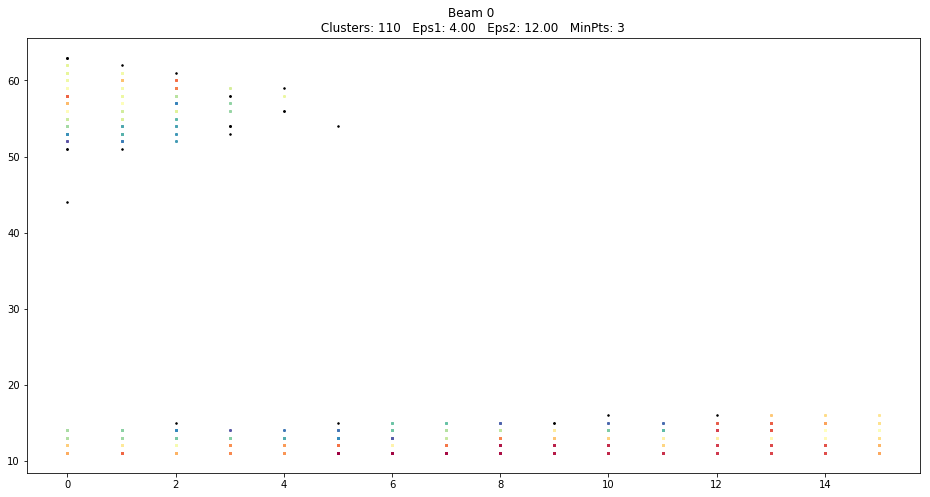

In [34]:
# #############################################################################
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
range_max = data_dict['nrang'][0]


fig = plt.figure(figsize=(16, 8))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]


    class_member_mask = (labels == k)
    #beam_mask = (beam == b)
    
    #print(class_member_mask.shape)
    
    #print(X.shape)

    xy = X[class_member_mask, :]
    #print(xy.shape)
    plt.plot(xy[:, 0], xy[:, 1], '.', color=tuple(col), markersize=3)

    #xy = X[class_member_mask & beam_mask]
    #plt.plot(xy[:, 0], xy[:, 1], '.', color=tuple(col), markersize=3)

#plt.xlim((np.min(time), np.max(time)))
#plt.ylim((0, range_max))
plt.title('Beam %d \n Clusters: %d   Eps1: %.2f   Eps2: %.2f   MinPts: %d ' % (b, n_clusters_, space_eps, time_eps, min_pts))
plt.show()
#plt.savefig('sas beam ' + str(b) + ' dbscan clusters.png')
#plt.close()


In [21]:
from superdarn_cluster.utilities import plot_clusters

stats_i = [0, 1, 2, 3, 4, 7, 8]
data_flat_unscaled[:, 2] = np.abs(data_flat_unscaled[:, 2])
data_flat_unscaled[:, 2] = np.abs(data_flat_unscaled[:, 2])

plot_clusters(labels, data_flat_unscaled[:, stats_i], data_flat_unscaled[:, 6], 
               gate, vel, np.array(feature_names)[stats_i], range_max, start_time, end_time, save=True)